# Introduction

This project is a sample training exercise designed to analyze the Synthea COVID-19 dataset, simulating real-world healthcare data analysis. Using SQLite in Jupyter Notebook, it explores patient outcomes for individuals diagnosed with COVID-19, focusing on hospital admissions, ICU stays, ventilation, recovery, and death, alongside lab value trends for survivors and non-survivors. The analysis provides insights into disease progression, care pathways, and outcome distributions, visualized through tables and plots, serving as a practical learning tool for SQL-based data analysis.

## Data Description

The Synthea COVID-19 dataset, sourced from [synthea.mitre.org](https://synthea.mitre.org), is a synthetic dataset simulating patient health records during the COVID-19 pandemic. It includes:
- **patients**: Demographics (e.g., `Id`, `BIRTHDATE`, `DEATHDATE`, `GENDER`, `RACE`).
- **conditions**: Diagnoses (e.g., `PATIENT`, `START`, `CODE`), including COVID-19 (`840539006`).
- **encounters**: Visits (e.g., `PATIENT`, `START`, `CODE`, `REASONCODE`), covering inpatient (`1505002`) and ICU (`305351004`) encounters.
- **care_plans**: Treatment plans (e.g., `PATIENT`, `START`, `STOP`, `CODE`), including home isolation (`736376001`).
- **observations**: Lab results (e.g., `PATIENT`, `DATE`, `CODE`, `VALUE`), such as SARS-CoV-2 tests (`94531-1`) and biomarkers (e.g., D-dimer `48065-7`).
- **procedures**: Procedures (e.g., `PATIENT`, `START`, `CODE`), including ventilation (`26763009`).

The dataset uses SNOMED-CT and LOINC codes, enabling detailed analysis for training purposes.

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load CSV files
patients = pd.read_csv('patients.csv')
encounters = pd.read_csv('encounters.csv')
conditions = pd.read_csv('conditions.csv')
observations = pd.read_csv("observations.csv")
care_plans = pd.read_csv("careplans.csv")
devices = pd.read_csv("devices.csv")
supplies = pd.read_csv('supplies.csv')
procedures = pd.read_csv("procedures.csv")
medications = pd.read_csv("medications.csv")

# Create SQLite database
conn = sqlite3.connect('synthea_covid19.db')

# Write data to SQL tables
patients.to_sql('patients', conn, if_exists='replace', index=False)
encounters.to_sql('encounters', conn, if_exists='replace', index=False)
conditions.to_sql('conditions', conn, if_exists='replace', index=False)
observations.to_sql('observations', conn, if_exists='replace', index=False)
care_plans.to_sql('care_plans', conn, if_exists='replace', index=False)
devices.to_sql('devices', conn, if_exists='replace', index=False)
supplies.to_sql('supplies', conn, if_exists='replace', index=False)
procedures.to_sql('procedures', conn, if_exists='replace', index=False)
medications.to_sql('medications', conn, if_exists='replace', index=False)



431262

In [3]:
%load_ext sql
%sql sqlite:///synthea_covid19.db
%config SqlMagic.autopandas = True

#### 1. Health outcomes Table



In [4]:

conn = sqlite3.connect('synthea_covid19.db')

outcomes_query = """
-- Grab IDs for patients with admission due to COVID-19

WITH InpatientIds AS (
    SELECT DISTINCT PATIENT
    FROM encounters
    WHERE REASONCODE = '840539006' AND CODE = '1505002'
),
--Survivors are the union of those who have completed isolation at home or have a negative SARS-CoV-2 test

SurvivorIds AS (
    SELECT PATIENT                     --Grabs IDs for patients that have completed the care plan for isolation at home
    FROM care_plans
    WHERE CODE = '736376001' 
      AND STOP IS NOT NULL 
      AND REASONCODE = '840539006'
    UNION                               --This grabs every patient with a negative SARS-CoV-2 test
    SELECT PATIENT
    FROM observations
    WHERE CODE = '94531-1' 
      AND VALUE = 'Not detected (qualifier value)'
),
--Grabs IDs for all patients that died in the simulation

DeceasedIds AS (
    SELECT Id
    FROM patients
    WHERE DEATHDATE IS NOT NULL
),

--Create the outcome table
Outcomes AS (
    SELECT 
        c.DESCRIPTION AS outcome,
        COUNT(DISTINCT c.PATIENT) AS total,
        COUNT(DISTINCT CASE WHEN s.PATIENT IS NOT NULL THEN c.PATIENT END) AS survivors,
        COUNT(DISTINCT CASE WHEN d.Id IS NOT NULL THEN c.PATIENT END) AS non_survivors
    FROM conditions c
    INNER JOIN InpatientIds i ON c.PATIENT = i.PATIENT
    LEFT JOIN SurvivorIds s ON c.PATIENT = s.PATIENT
    LEFT JOIN DeceasedIds d ON c.PATIENT = d.Id
    WHERE c.CODE IN ('105592009', '409622000', '67782005', '84114007', 
                     '769239001', '64779008', '233846008', '14669001')
    GROUP BY c.DESCRIPTION
),
InpatientCount AS (
    SELECT COUNT(DISTINCT PATIENT) AS total_inpatients
    FROM InpatientIds
)
SELECT 
    o.outcome,
    o.total,
    ROUND(o.total * 1.0 / ic.total_inpatients, 6) AS percent_of_inpatient,
    o.survivors,
    ROUND(o.survivors * 1.0 / o.total, 6) AS percent_survivors,
    o.non_survivors,
    ROUND(o.non_survivors * 1.0 / o.total, 6) AS percent_non_survivors
FROM Outcomes o
CROSS JOIN InpatientCount ic
ORDER BY o.total DESC;
"""
outcomes_result = pd.read_sql_query(outcomes_query, conn)
print("Health Outcomes Table:")
print(outcomes_result)

# Close connection
conn.close()

Health Outcomes Table:
                                          outcome  total  \
0  Acute respiratory distress syndrome (disorder)    234   
1                        Heart failure (disorder)    145   

   percent_of_inpatient  survivors  percent_survivors  non_survivors  \
0              0.125335          8           0.034188            226   
1              0.077665         18           0.124138            127   

   percent_non_survivors  
0               0.965812  
1               0.875862  


#### 2. Lab values Table


In [5]:
# Open connection
conn = sqlite3.connect('synthea_covid19.db')

# Run lab values query
lab_query = """
--Select COVID-19 conditions out of all conditions in the simulation

WITH CovidPatients AS (
    SELECT c.PATIENT, c.START AS diagnosis_date
    FROM conditions c
    WHERE c.CODE = '840539006'
),
--Survivors are the union of those who have completed isolation at home or have a negative SARS-CoV-2 test.

SurvivorIds AS (
    SELECT PATIENT
    FROM care_plans
    WHERE CODE = '736376001' 
      AND STOP IS NOT NULL 
      AND REASONCODE = '840539006'
    UNION
    SELECT PATIENT
    FROM observations
    WHERE CODE = '94531-1' 
      AND VALUE = 'Not detected (qualifier value)'
),
--Selects lab values of interest from all observations

LabObs AS (
    SELECT 
        o.PATIENT,
        o.DATE,
        o.CODE,
        o.DESCRIPTION,
        o.VALUE,
        o.UNITS,
        cp.diagnosis_date,
        CASE WHEN s.PATIENT IS NOT NULL THEN 1 ELSE 0 END AS survivor,
        JULIANDAY(o.DATE) - JULIANDAY(cp.diagnosis_date) AS days_since_diagnosis
    FROM observations o
    JOIN CovidPatients cp ON o.PATIENT = cp.PATIENT
    LEFT JOIN SurvivorIds s ON o.PATIENT = s.PATIENT
    WHERE o.CODE IN ('48065-7', '26881-3', '2276-4', '89579-7', '2532-0', '731-0', '14804-9')
      AND o.DATE >= cp.diagnosis_date
      AND o.VALUE NOT LIKE '%[^0-9.]%'
      AND CAST(o.VALUE AS FLOAT) IS NOT NULL
)
SELECT 
    DESCRIPTION,
    survivor,
    AVG(CAST(VALUE AS FLOAT)) AS avg_value,
    MIN(CAST(VALUE AS FLOAT)) AS min_value,
    MAX(CAST(VALUE AS FLOAT)) AS max_value,
    AVG(days_since_diagnosis) AS avg_days_since_diagnosis,
    COUNT(*) AS observation_count
FROM LabObs
GROUP BY DESCRIPTION, survivor
ORDER BY DESCRIPTION, survivor;
"""
lab_result = pd.read_sql_query(lab_query, conn)

# Display results
print("\nLab Values Table:")
print(lab_result)


# Close connection
conn.close()


Lab Values Table:
                                          DESCRIPTION  survivor    avg_value  \
0           Ferritin [Mass/volume] in Serum or Plasma         0  1448.810747   
1           Ferritin [Mass/volume] in Serum or Plasma         1   461.988460   
2   Fibrin D-dimer FEU [Mass/volume] in Platelet p...         0     9.107864   
3   Fibrin D-dimer FEU [Mass/volume] in Platelet p...         1     0.429671   
4      Interleukin 6 [Mass/volume] in Serum or Plasma         0    14.048148   
5      Interleukin 6 [Mass/volume] in Serum or Plasma         1     5.541026   
6   Lactate dehydrogenase [Enzymatic activity/volu...         0   358.019364   
7   Lactate dehydrogenase [Enzymatic activity/volu...         1   243.818397   
8   Lymphocytes [#/volume] in Blood by Automated c...         0     0.578447   
9   Lymphocytes [#/volume] in Blood by Automated c...         1     1.012656   
10  Troponin I.cardiac [Mass/volume] in Serum or P...         0    31.356029   
11  Troponin I.cardia

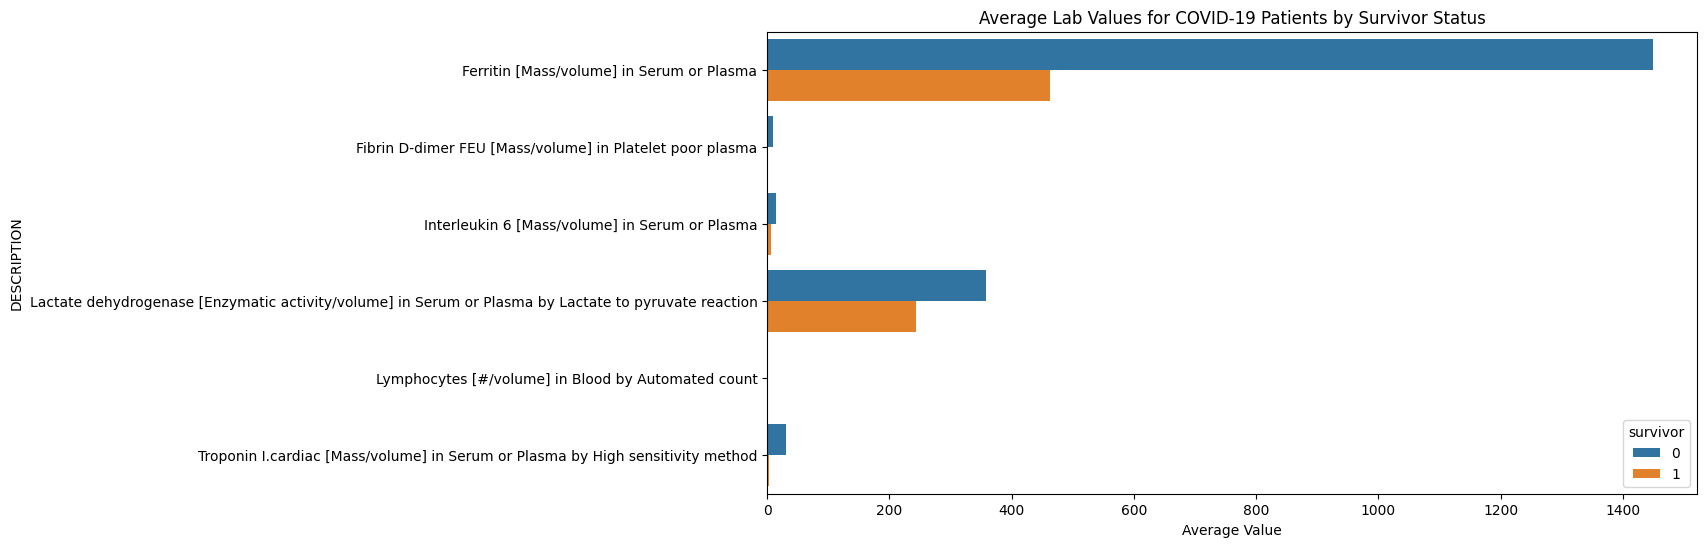

In [6]:
# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_value', y='DESCRIPTION', hue='survivor', data=lab_result)
plt.title('Average Lab Values for COVID-19 Patients by Survivor Status')
plt.xlabel('Average Value')
plt.show()

#### 3- Outcomes for all COVID-19 Patients

In [7]:
# Open connection
conn = sqlite3.connect('synthea_covid19.db')

# Run outcomes table query
outcomes_table_query = """
WITH CovidPatients AS (
    SELECT c.PATIENT, c.START AS diagnosis_date, p.DEATHDATE, p.Id
    FROM conditions c
    JOIN patients p ON c.PATIENT = p.Id
    WHERE c.CODE = '840539006'
),
IsolationIds AS (
    SELECT PATIENT
    FROM care_plans
    WHERE CODE = '736376001' AND REASONCODE = '840539006'
),
InpatientIds AS (
    SELECT PATIENT
    FROM encounters
    WHERE REASONCODE = '840539006' AND CODE = '1505002'
),
SurvivorIds AS (
    SELECT PATIENT
    FROM care_plans
    WHERE CODE = '736376001' AND STOP IS NOT NULL AND REASONCODE = '840539006'
    UNION
    SELECT PATIENT
    FROM observations
    WHERE CODE = '94531-1' AND VALUE = 'Not detected (qualifier value)'
),
IcuIds AS (
    SELECT PATIENT
    FROM encounters
    WHERE CODE = '305351004'
),
VentIds AS (
    SELECT PATIENT
    FROM procedures
    WHERE CODE = '26763009'
),
-- Create with boolean columns representing various outcomes

OutcomeFlags AS (
    SELECT 
        cp.PATIENT,
        CASE WHEN i.PATIENT IS NOT NULL THEN 1 ELSE 0 END AS isolation,
        CASE WHEN ip.PATIENT IS NOT NULL THEN 1 ELSE 0 END AS admit,
        CASE WHEN s.PATIENT IS NOT NULL THEN 1 ELSE 0 END AS recovered,
        CASE WHEN cp.DEATHDATE IS NOT NULL THEN 1 ELSE 0 END AS death,
        CASE WHEN icu.PATIENT IS NOT NULL THEN 1 ELSE 0 END AS icu_admit,
        CASE WHEN v.PATIENT IS NOT NULL THEN 1 ELSE 0 END AS ventilated
    FROM CovidPatients cp
    LEFT JOIN IsolationIds i ON cp.PATIENT = i.PATIENT
    LEFT JOIN InpatientIds ip ON cp.PATIENT = ip.PATIENT
    LEFT JOIN SurvivorIds s ON cp.PATIENT = s.PATIENT
    LEFT JOIN IcuIds icu ON cp.PATIENT = icu.PATIENT
    LEFT JOIN VentIds v ON cp.PATIENT = v.PATIENT
),
Counts AS (
    SELECT 
        COUNT(*) AS total_covid,
        SUM(admit) AS total_hospitalized,
        SUM(icu_admit) AS total_icu,
        SUM(ventilated) AS total_ventilated
    FROM OutcomeFlags
),
OutcomeStats AS (
    SELECT 
        'Home Isolation' AS Outcome,
        SUM(isolation) * 1.0 / total_covid AS All_Patients,
        SUM(CASE WHEN admit = 1 THEN isolation ELSE 0 END) * 1.0 / total_hospitalized AS Hospitalized,
        SUM(CASE WHEN icu_admit = 1 THEN isolation ELSE 0 END) * 1.0 / total_icu AS ICU_Admitted,
        SUM(CASE WHEN ventilated = 1 THEN isolation ELSE 0 END) * 1.0 / total_ventilated AS Required_Ventilation
    FROM OutcomeFlags
    CROSS JOIN Counts
    UNION ALL
    SELECT 
        'Hospital Admission',
        SUM(admit) * 1.0 / total_covid,
        SUM(CASE WHEN admit = 1 THEN admit ELSE 0 END) * 1.0 / total_hospitalized,
        SUM(CASE WHEN icu_admit = 1 THEN admit ELSE 0 END) * 1.0 / total_icu,
        SUM(CASE WHEN ventilated = 1 THEN admit ELSE 0 END) * 1.0 / total_ventilated
    FROM OutcomeFlags
    CROSS JOIN Counts
    UNION ALL
    SELECT 
        'ICU Admission',
        SUM(icu_admit) * 1.0 / total_covid,
        SUM(CASE WHEN admit = 1 THEN icu_admit ELSE 0 END) * 1.0 / total_hospitalized,
        SUM(CASE WHEN icu_admit = 1 THEN icu_admit ELSE 0 END) * 1.0 / total_icu,
        SUM(CASE WHEN ventilated = 1 THEN icu_admit ELSE 0 END) * 1.0 / total_ventilated
    FROM OutcomeFlags
    CROSS JOIN Counts
    UNION ALL
    SELECT 
        'Ventilated',
        SUM(ventilated) * 1.0 / total_covid,
        SUM(CASE WHEN admit = 1 THEN ventilated ELSE 0 END) * 1.0 / total_hospitalized,
        SUM(CASE WHEN icu_admit = 1 THEN ventilated ELSE 0 END) * 1.0 / total_icu,
        SUM(CASE WHEN ventilated = 1 THEN ventilated ELSE 0 END) * 1.0 / total_ventilated
    FROM OutcomeFlags
    CROSS JOIN Counts
    UNION ALL
    SELECT 
        'Recovered',
        SUM(recovered) * 1.0 / total_covid,
        SUM(CASE WHEN admit = 1 THEN recovered ELSE 0 END) * 1.0 / total_hospitalized,
        SUM(CASE WHEN icu_admit = 1 THEN recovered ELSE 0 END) * 1.0 / total_icu,
        SUM(CASE WHEN ventilated = 1 THEN recovered ELSE 0 END) * 1.0 / total_ventilated
    FROM OutcomeFlags
    CROSS JOIN Counts
    UNION ALL
    SELECT 
        'Death',
        SUM(death) * 1.0 / total_covid,
        SUM(CASE WHEN admit = 1 THEN death ELSE 0 END) * 1.0 / total_hospitalized,
        SUM(CASE WHEN icu_admit = 1 THEN death ELSE 0 END) * 1.0 / total_icu,
        SUM(CASE WHEN ventilated = 1 THEN death ELSE 0 END) * 1.0 / total_ventilated
    FROM OutcomeFlags
    CROSS JOIN Counts
)
SELECT 
    Outcome,
    ROUND(All_Patients, 6) AS All_Patients,
    ROUND(Hospitalized, 6) AS Hospitalized,
    ROUND(ICU_Admitted, 6) AS ICU_Admitted,
    ROUND(Required_Ventilation, 6) AS Required_Ventilation
FROM OutcomeStats
ORDER BY All_Patients DESC;
"""
outcomes_table_result = pd.read_sql_query(outcomes_table_query, conn)
print("Outcomes Table for COVID-19 Patients:")
print(outcomes_table_result)


# Close connection
conn.close()

Outcomes Table for COVID-19 Patients:
              Outcome  All_Patients  Hospitalized  ICU_Admitted  \
0           Recovered      0.821100      0.476705      0.156575   
1      Home Isolation      0.667866      0.027454      0.022706   
2  Hospital Admission      0.341510      1.000000      1.000000   
3       ICU Admission      0.200208      0.586245      1.000000   
4          Ventilated      0.191874      0.561841      0.958373   
5               Death      0.179847      0.524404      0.843898   

   Required_Ventilation  
0              0.120434  
1              0.022211  
2              1.000000  
3              1.000000  
4              1.000000  
5              0.879566  


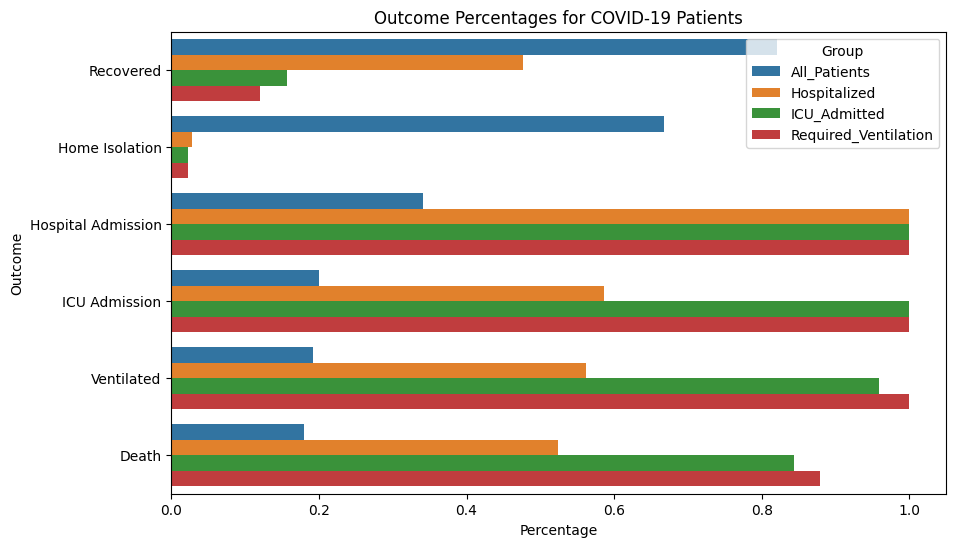

In [8]:
# Visualize
plt.figure(figsize=(10, 6))
outcomes_melted = outcomes_table_result.melt(id_vars='Outcome', 
                                            value_vars=['All_Patients', 'Hospitalized', 'ICU_Admitted', 'Required_Ventilation'],
                                            var_name='Group', value_name='Percentage')
sns.barplot(x='Percentage', y='Outcome', hue='Group', data=outcomes_melted)
plt.title('Outcome Percentages for COVID-19 Patients')
plt.xlabel('Percentage')
plt.show()


# SQL Best Practices and Areas for Improvement

## Good Practices Implemented
The SQL code in this training project follows several best practices to ensure readability, maintainability, and performance:

- **Common Table Expressions (CTEs)**: CTEs (e.g., `CovidPatients`, `SurvivorIds`) modularize complex queries, enhancing readability. Example: `WITH CovidPatients AS (SELECT c.PATIENT, c.START AS diagnosis_date FROM conditions c WHERE c.CODE = '840539006')`.
- **Clear Aliasing**: Table aliases (e.g., `c` for `conditions`, `p` for `patients`) reduce ambiguity, as in `JOIN patients p ON c.PATIENT = p.Id`.
- **Explicit Joins**: Uses `INNER JOIN` and `LEFT JOIN` with clear `ON` clauses, e.g., `LEFT JOIN SurvivorIds s ON cp.PATIENT = s.PATIENT`.
- **Unique Results**: `DISTINCT` prevents duplicate patient IDs, e.g., `SELECT DISTINCT PATIENT FROM encounters`.
- **Boolean Logic**: `CASE` statements create flags like `isolation`, e.g., `CASE WHEN s.PATIENT IS NOT NULL THEN 1 ELSE 0 END AS survivor`.
- **Robust Aggregations**: `COUNT`, `AVG`, and `SUM` compute metrics, e.g., `AVG(CAST(VALUE AS FLOAT)) AS avg_value`.
- **Numeric Handling**: Filters numeric values with `VALUE NOT LIKE '%[^0-9.]%'` and `CAST`, ensuring reliable calculations.
- **Set Operations**: `UNION` combines survivor criteria, e.g., in `SurvivorIds`.

## Areas for Improvement
To enhance the code, the following improvements are recommended:

- **Indexing**: Indexes (e.g., `CREATE INDEX idx_conditions_patient`) improve performance but need workflow documentation.
  - **Action**: Add `CREATE INDEX IF NOT EXISTS idx_conditions_patient ON conditions(PATIENT, CODE);`.
- **Query Optimization**: Multiple `UNION ALL` statements in the outcomes table can be refactored using `CASE`.
  - **Action**: Consolidate aggregations into one block.
- **Schema Validation**: Prevents errors like `KeyError` from column mismatches (e.g., `Id` vs. `ID`).
  - **Action**: Run `PRAGMA table_info(table_name);` before queries.
- **Error Handling**: Avoids division by zero in percentages.
  - **Action**: Use `NULLIF`, e.g., `ROUND(total * 1.0 / NULLIF(total_covid, 0), 6)`.
- **Documentation**: Inline comments improve maintainability.
  - **Action**: Add comments, e.g., `-- Identify COVID-19 patients`.
- **Avoid Hard-Coded Values**: Codes like `840539006` reduce flexibility.
  - **Action**: Use Python variables or a reference table.
- **Connection Management**: Connection closure is good, but context managers are safer.
  - **Action**: Use `with sqlite3.connect('synthea_covid19.db') as conn:`.



# Acknowledgments

This sample training project was developed with the assistance of Grok, created by xAI. Grok provided guidance on SQL query development, debugging, best practices, and project structuring, enhancing the learning experience and ensuring robust analysis of the Synthea COVID-19 dataset.